In [1]:
%%capture
!pip install gdown

In [2]:
import gdown
id = '1LB53KldZ_hG_Kc2wEBmRjLH0Js80WGgr'
gdown.download(id=id, output='trainval.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1LB53KldZ_hG_Kc2wEBmRjLH0Js80WGgr
From (redirected): https://drive.google.com/uc?id=1LB53KldZ_hG_Kc2wEBmRjLH0Js80WGgr&confirm=t&uuid=f298d5cf-2907-4e77-8fb6-e26ee494fd9c
To: /kaggle/working/trainval.zip
100%|██████████| 756M/756M [00:07<00:00, 95.3MB/s] 


'trainval.zip'

In [3]:
%%capture
!unzip trainval.zip

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
from skimage import io, color
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchmetrics import JaccardIndex, Dice
from tqdm import tqdm
from sklearn.metrics import jaccard_score
import gc
import cv2

In [5]:
# Load images from folders A and B
folder_A = 'trainval/A'
folder_B = 'trainval/B'
folder_label = 'trainval/label'

In [6]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [7]:
print(device)

cuda


In [8]:
# Function to load images from directory
def load_images_from_folder(folder, is_gray = True):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename)).astype(np.uint8)
        if img is not None:
            if is_gray:
                images.append(color.rgb2gray(img))
            else:    
                images.append(img)
    return images


In [9]:
images_A = load_images_from_folder(folder_A, is_gray=False)

In [10]:
images_B = load_images_from_folder(folder_B, is_gray=False)

In [11]:
labels = load_images_from_folder(folder_label, is_gray = False)

In [12]:
no_changes = []
changes = []
for i in range(len(labels)):
    if np.sum(labels[i]) == 0:
        no_changes.append(i)
    else:
        changes.append(i)

In [13]:
print(f'Number of images with no changes: {len(no_changes)}')
print(f'Number of images with changes: {len(changes)}')

Number of images with no changes: 3232
Number of images with changes: 1636


In [14]:
reomve_no_changes, not_remove_no_change = train_test_split(no_changes, test_size = 0.3)

In [15]:
print(len(reomve_no_changes),len(not_remove_no_change))

2262 970


In [16]:
images_A_removed_no_change = [images_A[i] for i in range(len(images_A)) if i not in reomve_no_changes]
images_B_removed_no_change = [images_B[i] for i in range(len(images_B)) if i not in reomve_no_changes]
labels_removed_no_change = [labels[i] for i in range(len(labels)) if i not in reomve_no_changes]

In [17]:
print(len(images_A_removed_no_change), len(images_B_removed_no_change), len(labels_removed_no_change)) 

2606 2606 2606


In [18]:
images_A_train, images_A_val, images_B_train, images_B_val, labels_train, labels_val = train_test_split(images_A_removed_no_change, images_B_removed_no_change, labels_removed_no_change, test_size=0.3)

In [19]:
print(len(images_A_train),len(images_A_val))

1824 782


In [20]:
def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def vertical_reflection(image):
    reflected_image = cv2.flip(image, 0)
    return reflected_image

def horizontal_reflection(image):
    reflected_image = cv2.flip(image, 1)
    return reflected_image

In [21]:
origina_length = len(images_A_train)

In [22]:
for i in range(origina_length):
    for angle in range(90, 360, 90):
        rotated_A = rotate_image(images_A_train[i], angle)
        images_A_train.append(rotated_A)
        
        rotated_B = rotate_image(images_B_train[i], angle)
        images_B_train.append(rotated_B)
        
        rotated_labels = rotate_image(labels_train[i], angle)
        labels_train.append(rotated_labels)
        

In [23]:
for i in range(origina_length):
    reflected_h_A = horizontal_reflection(images_A_train[i])
    images_A_train.append(reflected_h_A)
    reflected_v_A = vertical_reflection(images_A_train[i])
    images_A_train.append(reflected_v_A)
    
    reflected_h_B = horizontal_reflection(images_B_train[i])
    images_B_train.append(reflected_h_B)
    reflected_v_B = vertical_reflection(images_B_train[i])
    images_B_train.append(reflected_v_B)
    
    reflected_h_label = horizontal_reflection(labels_train[i])
    labels_train.append(reflected_h_label)
    reflected_v_label = vertical_reflection(labels_train[i])
    labels_train.append(reflected_v_label)

In [24]:
for i in not_remove_no_change:
    images_A_train.append(images_A[i])
    images_B_train.append(images_B[i])
    labels_train.append(labels[i])

In [25]:
print(len(images_A_train), len(images_B_train), len(labels_train)) 
print(len(images_A_val), len(images_B_val), len(labels_val))

11914 11914 11914
782 782 782


In [26]:
nowLength = len(images_A_train)

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5, 0.5),
])

In [28]:
class ChangeDetectionDataset(Dataset):
    def __init__(self, images_A, images_B, labels):
        self.images_A = images_A
        self.images_B = images_B
        self.labels = labels
#         self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_A = torch.tensor(self.images_A[idx], dtype=torch.float32).permute(2, 0, 1) / 255
        image_B = torch.tensor(self.images_B[idx], dtype=torch.float32).permute(2, 0, 1) / 255
        label = torch.tensor(self.labels[idx], dtype=torch.float32) / 255


        return image_A, image_B, label

In [29]:
class Channel_Attention(nn.Module):
    def __init__(self, channel):
        super(Channel_Attention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.query_conv = nn.Sequential(
            nn.Conv1d(in_channels=channel, out_channels=channel, kernel_size=1),
            )
        self.key_conv = nn.Sequential(
            nn.Conv1d(in_channels=channel, out_channels=channel, kernel_size=1),
            )
        self.value_conv = nn.Sequential(
            nn.Conv1d(in_channels=channel, out_channels=channel, kernel_size=1),
            )
        self.sigmoid = nn.Sigmoid()
        self.sm = nn.Softmax(-1)

        
    def forward(self, x):
        y = self.avg_pool(x)
        y = y.squeeze(-1)
        query = self.query_conv(y).transpose(-1, -2)
        key = self.key_conv(y)
        attention = torch.bmm(query, key)
        attention = self.sm(attention)
        value = self.value_conv(y)
        out = torch.bmm(value, attention).unsqueeze(-1)
        out = self.sigmoid(out)
        x = x * out.expand_as(x)
        return x

In [30]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        ## Attention
        self.attention = Channel_Attention(out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        ## Attention
        x1 = self.attention(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [31]:
class UNet_Model(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet_Model, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, n_classes))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_A, x_B):
        x = torch.cat([x_A, x_B], dim=1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = self.sigmoid(x)
        return x

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        self.sigmoid = torch.utils.checkpoint(self.sigmoid)

In [32]:
class Spatial_Attention(torch.nn.Module):
    def __init__(self):
        super(Spatial_Attention, self).__init__()

    def forward(self, x):
        _, _, h, w = x.size()
        q = x.mean(dim=[2, 3], keepdim=True)
        k = x
        square = (k - q).pow(2)
        sigma = square.sum(dim=[2, 3], keepdim=True) / (h * w)
        att_score = square / (2 * sigma + np.finfo(np.float32).eps) + 0.5
        att_weight = nn.Sigmoid()(att_score)

        return x * att_weight

class First_DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(First_DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Conv_With_Attention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv_With_Attention, self).__init__()
        out_channels_without_att = out_channels // 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_without_att, kernel_size = 1, stride = 1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels_without_att),
            nn.ReLU(inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels_without_att, out_channels_without_att, kernel_size = 3, stride = 1, padding = 1, groups= out_channels_without_att // 4, bias=False),
            nn.BatchNorm2d(out_channels_without_att),
            nn.ReLU(inplace=True),
        )

        self.attention = Spatial_Attention()

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.attention(x2)
        out = torch.cat([x1, x3], dim=1)
        return out


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.Conv = nn.Sequential(
            Conv_With_Attention(in_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            Conv_With_Attention(out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, input):
        return self.Conv(input)


class UNet_Siamese(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet_Siamese, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1_1 = First_DoubleConv(in_channels, 32)
        self.Conv1_2 = First_DoubleConv(in_channels, 32)
        self.Conv2_1 = DoubleConv(32, 64)
        self.Conv2_2 = DoubleConv(32, 64)
        self.Conv3_1 = DoubleConv(64, 128)
        self.Conv3_2 = DoubleConv(64, 128)
        self.Conv4_1 = DoubleConv(128, 256)
        self.Conv4_2 = DoubleConv(128, 256)
        self.Conv5_1 = DoubleConv(256, 512)
        self.Conv5_2 = DoubleConv(256, 512)

        self.Up5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.Up_conv5 = DoubleConv(512, 256)

        self.Up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.Up_conv4 = DoubleConv(256, 128)

        self.Up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.Up_conv3 = DoubleConv(128, 64)

        self.Up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.Up_conv2 = DoubleConv(64, 32)

        self.Conv_1x1 = nn.Conv2d(32, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x1, x2):
        # encoding
        c1_1 = self.Conv1_1(x1)
        c1_2 = self.Conv1_2(x2)
        x1 = torch.abs(torch.sub(c1_1, c1_2))
        
        c2_1 = self.Maxpool(c1_1)
        c2_1 = self.Conv2_1(c2_1)
        c2_2 = self.Maxpool(c1_2)
        c2_2 = self.Conv2_2(c2_2)
        x2 = torch.abs(torch.sub(c2_1, c2_2))
        
        c3_1 = self.Maxpool(c2_1)
        c3_1 = self.Conv3_1(c3_1)
        c3_2 = self.Maxpool(c2_2)
        c3_2 = self.Conv3_2(c3_2)
        x3 = torch.abs(torch.sub(c3_1, c3_2))

        c4_1 = self.Maxpool(c3_1)
        c4_1 = self.Conv4_1(c4_1)
        c4_2 = self.Maxpool(c3_2)
        c4_2 = self.Conv4_2(c4_2)
        x4 = torch.abs(torch.sub(c4_1, c4_2))

        c5_1 = self.Maxpool(c4_1)
        c5_1 = self.Conv5_1(c5_1)
        c5_2 = self.Maxpool(c4_2)
        c5_2 = self.Conv5_2(c5_2)
        x5 = torch.abs(torch.sub(c5_1, c5_2))
        x5 = nn.Dropout2d(0.2)(x5)

        # decoding
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)
        d5 = nn.Dropout2d(0.2)(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)
        d4 = nn.Dropout2d(0.2)(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)
        d3 = nn.Dropout2d(0.2)(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)
        d2 = nn.Dropout2d(0.2)(d2)

        d1 = self.Conv_1x1(d2)
        out = nn.Sigmoid()(d1)

        return out

In [33]:
def dice_loss(pred, target, weight = 0.5, smooth=1):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=0).sum(dim=0)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=0).sum(dim=0) + target.sum(dim=0).sum(dim=0) + smooth)))
    loss = loss.mean() * weight
    loss += F.binary_cross_entropy(pred,target) * (1 - weight)
    return loss

In [34]:
def train(images_A_train, images_B_train, labels_train, images_A_val, images_B_val, labels_val, num_epochs=10, batch_size=32, learning_rate=0.01):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model = UNet_Model(n_channels=6, n_classes=1).to(device)
    model = UNet_Siamese(in_channels=3, out_channels=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    print('Loading Data ...')
    train_dataset = ChangeDetectionDataset(images_A_train, images_B_train, labels_train)
    val_dataset = ChangeDetectionDataset(images_A_val, images_B_val, labels_val)
    # train_size = int(0.8 * len(dataset))
    # val_size = len(dataset) - train_size
    # train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    criterion = torch.nn.BCELoss(weight=tensor(10).to(device))
    jaccard = JaccardIndex(task='binary').to(device)
    print('Training ...')
    for epoch_num in range(num_epochs):
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
        total_loss = 0
        total_intersections = 0
        total_unions = 0
        # number_of_batches = 0
        jaccard_index = 0
        jaccardArr = []
        for a, b, l in tqdm(train_loader):
            # number_of_batches += 1
            a, b, l = a.to(device), b.to(device), l.to(device)
            optimizer.zero_grad()
            outputs = model(a,b)
            l = l.reshape(outputs.shape)
            outputs_binary = (outputs>0.5) * 1
            total_intersections += np.logical_and(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
            total_unions += np.logical_or(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
#             loss = dice_loss(outputs, l, 0.3, 0)
            loss = criterion(outputs, l)
            total_loss += loss
            loss.backward()
            optimizer.step()

            for i in range(len(outputs_binary)):
                intersection = np.logical_and(outputs_binary[i].cpu().numpy(), l[i].cpu().numpy()).sum()
                union = np.logical_or(outputs_binary[i].cpu().numpy(), l[i].cpu().numpy()).sum()
                if union != 0:
                    jaccardArr.append((intersection)/(union))
                else:
                    jaccardArr.append(1)
        scheduler.step()
            
        epoch_loss = total_loss / len(images_A_train)
        epoch_jaccard = total_intersections / total_unions
        epoch_jaccard_index = jaccard_index / len(images_A_train)
        secondWay = np.array(jaccardArr).mean()
        print(
        f'Epochs: {epoch_num + 1} | Loss: {epoch_loss} | Epoch Jaccard Index : {epoch_jaccard} | Jaccard Avg : {secondWay} \n')
        
    print('Validation ...')
    model.eval()
    val_total_intersections = 0
    val_total_unions = 0
    with torch.no_grad():
        jaccardArr = []
        for a, b, l in tqdm(val_loader):
            a, b, l = a.to(device), b.to(device), l.to(device)
            outputs = model(a,b)
            outputs = outputs.reshape((-1,l.shape[1],l.shape[2]))
            outputs_binary = (outputs>0.5) * 1
            val_total_intersections += np.logical_and(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
            val_total_unions += np.logical_or(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
            for i in range(len(outputs_binary)):
                intersection = np.logical_and(outputs_binary[i].cpu().numpy(), l[i].cpu().numpy()).sum()
                union = np.logical_or(outputs_binary[i].cpu().numpy(), l[i].cpu().numpy()).sum()
                if union != 0:
                    jaccardArr.append((intersection)/(union))
                else:
                    jaccardArr.append(1)
        
    val_jaccard = val_total_intersections / val_total_unions
    secondWay = np.array(jaccardArr).mean()
    print(f'Validation Jaccard Index : {val_jaccard} | Jaccard Avg : {secondWay} ')
    return model

In [35]:
model = train(images_A_train, images_B_train, labels_train, images_A_val, images_B_val, labels_val, num_epochs=15, batch_size=25, learning_rate=0.01)

Loading Data ...
Training ...
LR 0.01


100%|██████████| 477/477 [06:08<00:00,  1.30it/s]


Epochs: 1 | Loss: 0.0810626894235611 | Epoch Jaccard Index : 0.44432462831529707 | Jaccard Avg : 0.5846203976825487 

LR 0.01


100%|██████████| 477/477 [06:05<00:00,  1.31it/s]


Epochs: 2 | Loss: 0.06133190542459488 | Epoch Jaccard Index : 0.564346063154193 | Jaccard Avg : 0.667556134478638 

LR 0.01


100%|██████████| 477/477 [06:05<00:00,  1.31it/s]


Epochs: 3 | Loss: 0.054562538862228394 | Epoch Jaccard Index : 0.6097052203250448 | Jaccard Avg : 0.6954258450758346 

LR 0.01


100%|██████████| 477/477 [06:04<00:00,  1.31it/s]


Epochs: 4 | Loss: 0.0505264587700367 | Epoch Jaccard Index : 0.6357180457012408 | Jaccard Avg : 0.71131438262694 

LR 0.001


100%|██████████| 477/477 [06:03<00:00,  1.31it/s]


Epochs: 5 | Loss: 0.04254258796572685 | Epoch Jaccard Index : 0.6868370602097098 | Jaccard Avg : 0.746473008920643 

LR 0.001


100%|██████████| 477/477 [06:03<00:00,  1.31it/s]


Epochs: 6 | Loss: 0.040623802691698074 | Epoch Jaccard Index : 0.7000881854352361 | Jaccard Avg : 0.7549964292394405 

LR 0.001


100%|██████████| 477/477 [06:03<00:00,  1.31it/s]


Epochs: 7 | Loss: 0.038740772753953934 | Epoch Jaccard Index : 0.7120604928824723 | Jaccard Avg : 0.7625462593154346 

LR 0.001


100%|██████████| 477/477 [06:03<00:00,  1.31it/s]


Epochs: 8 | Loss: 0.036845289170742035 | Epoch Jaccard Index : 0.7253382359420529 | Jaccard Avg : 0.7699422042033459 

LR 0.0001


100%|██████████| 477/477 [06:03<00:00,  1.31it/s]


Epochs: 9 | Loss: 0.03528691455721855 | Epoch Jaccard Index : 0.7357535894752719 | Jaccard Avg : 0.7750790112942638 

LR 0.0001


100%|██████████| 477/477 [06:03<00:00,  1.31it/s]


Epochs: 10 | Loss: 0.03497786819934845 | Epoch Jaccard Index : 0.7378782704222437 | Jaccard Avg : 0.7766034642452068 

LR 0.0001


100%|██████████| 477/477 [06:02<00:00,  1.31it/s]


Epochs: 11 | Loss: 0.03483712300658226 | Epoch Jaccard Index : 0.7395641565755618 | Jaccard Avg : 0.7769682873146834 

LR 0.0001


100%|██████████| 477/477 [06:03<00:00,  1.31it/s]


Epochs: 12 | Loss: 0.03462549299001694 | Epoch Jaccard Index : 0.7408242612523014 | Jaccard Avg : 0.7787489299270408 

LR 1e-05


100%|██████████| 477/477 [06:03<00:00,  1.31it/s]


Epochs: 13 | Loss: 0.034323591738939285 | Epoch Jaccard Index : 0.742580380946249 | Jaccard Avg : 0.7802960608694878 

LR 1e-05


100%|██████████| 477/477 [06:02<00:00,  1.31it/s]


Epochs: 14 | Loss: 0.03433210775256157 | Epoch Jaccard Index : 0.7424202631167685 | Jaccard Avg : 0.7794572312511681 

LR 1e-05


100%|██████████| 477/477 [06:02<00:00,  1.31it/s]


Epochs: 15 | Loss: 0.03445691242814064 | Epoch Jaccard Index : 0.7417261010650305 | Jaccard Avg : 0.7790565492205225 

Validation ...


100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


Validation Jaccard Index : 0.6891828004184054 | Jaccard Avg : 0.7378600979470687 


In [36]:
# # del model
# gc.collect()
# torch.cuda.empty_cache()

In [37]:
torch.save(model.state_dict(), 'model_2.pth')

In [47]:
checkpoint = {'model': UNet_Siamese(in_channels=3, out_channels=1),
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
model_cpu = model.cpu()

In [40]:
print(len(images_A), len(images_B), len(labels))

4868 4868 4868


In [41]:
dataset = ChangeDetectionDataset(images_A, images_B, labels)
data_loader = DataLoader(dataset, batch_size=25)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
val_total_intersections = 0
val_total_unions = 0
with torch.no_grad():
    jaccardArr = []
    for a, b, l in tqdm(data_loader):
        a, b, l = a.to(device), b.to(device), l.to(device)
        outputs = model(a,b)
        outputs = outputs.reshape((-1,l.shape[1],l.shape[2]))
        outputs_binary = (outputs>0.5) * 1
        val_total_intersections += np.logical_and(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
        val_total_unions += np.logical_or(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
        for i in range(len(outputs_binary)):
            intersection = np.logical_and(outputs_binary[i].cpu().numpy(), l[i].cpu().numpy()).sum()
            union = np.logical_or(outputs_binary[i].cpu().numpy(), l[i].cpu().numpy()).sum()
            if union != 0:
                jaccardArr.append((intersection)/(union))
            else:
                jaccardArr.append(1)
val_jaccard = val_total_intersections / val_total_unions
secondWay = np.array(jaccardArr).mean()
print(f'Validation Jaccard Index : {val_jaccard} | Jaccard Avg : {secondWay} ')

100%|██████████| 195/195 [00:43<00:00,  4.50it/s]

Validation Jaccard Index : 0.7320427776119702 | Jaccard Avg : 0.8513484652684357 


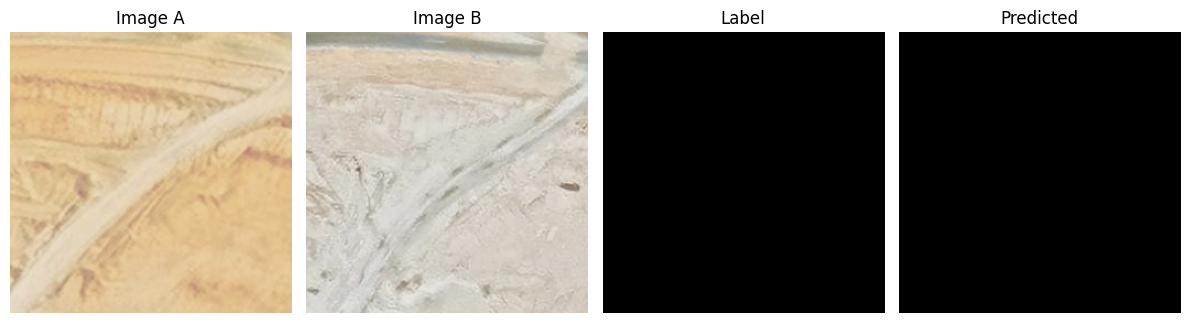

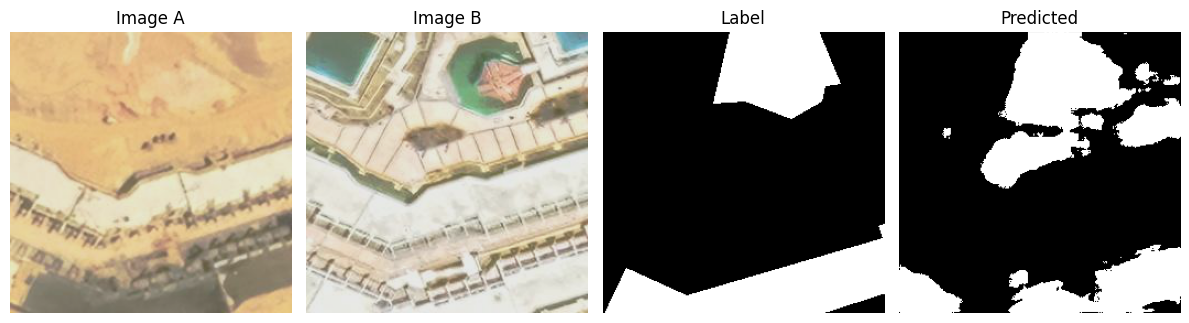

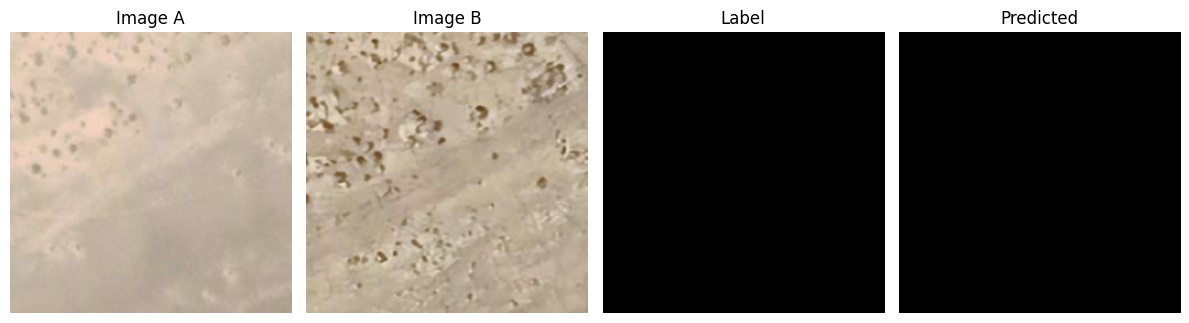

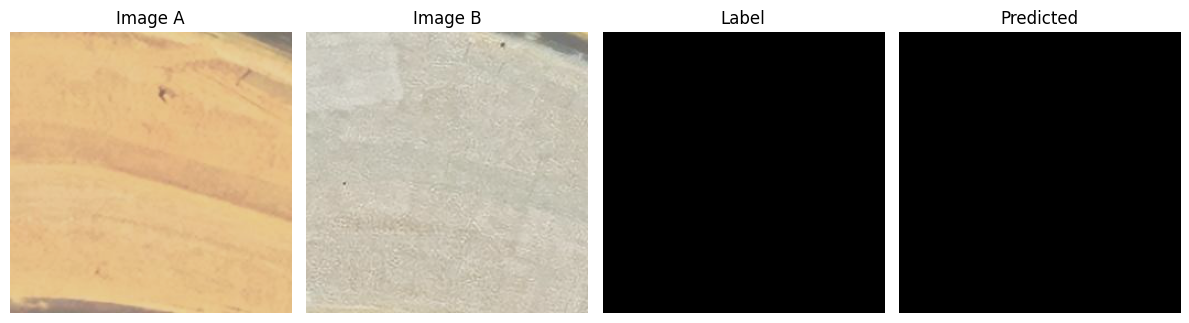

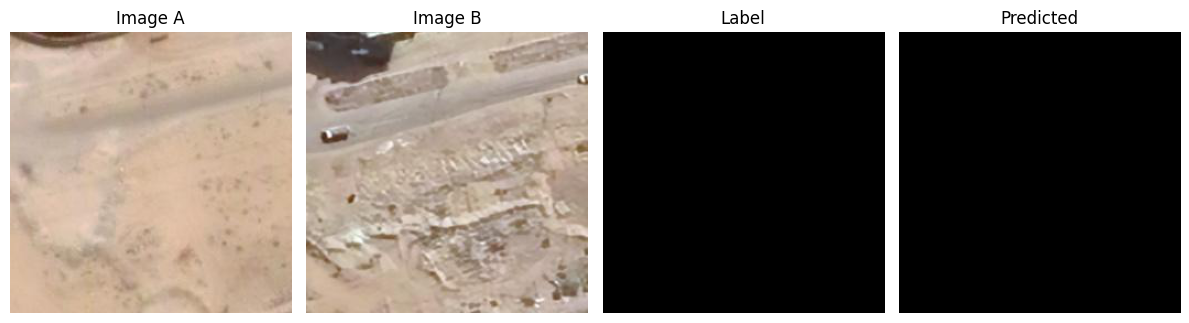

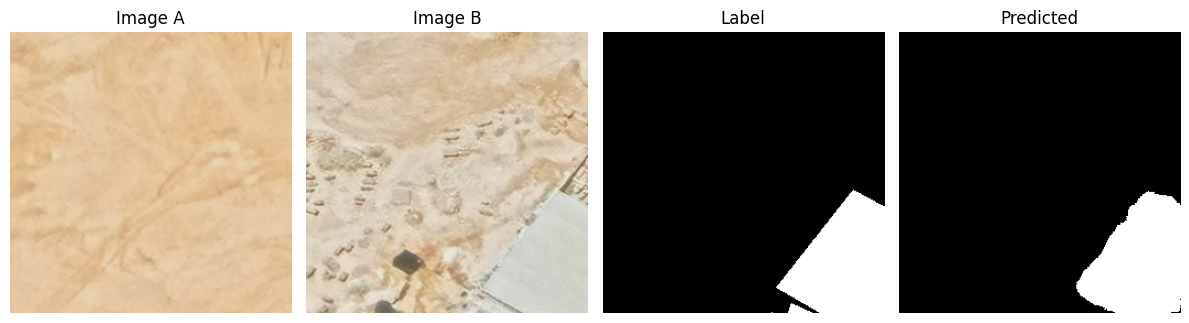

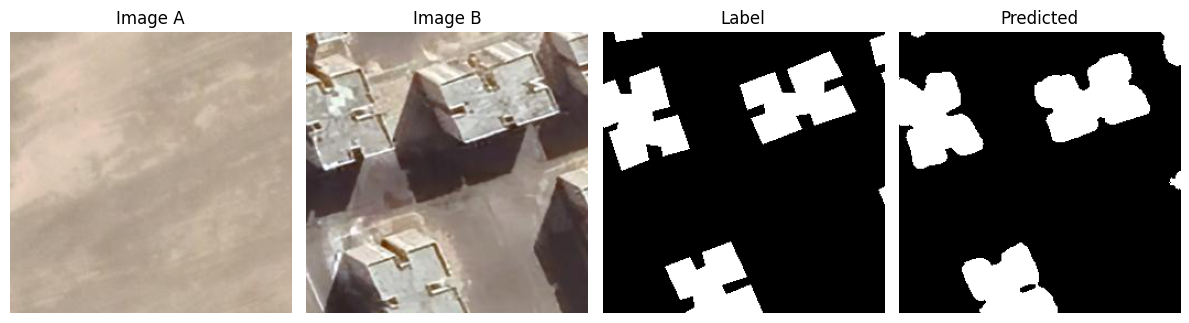

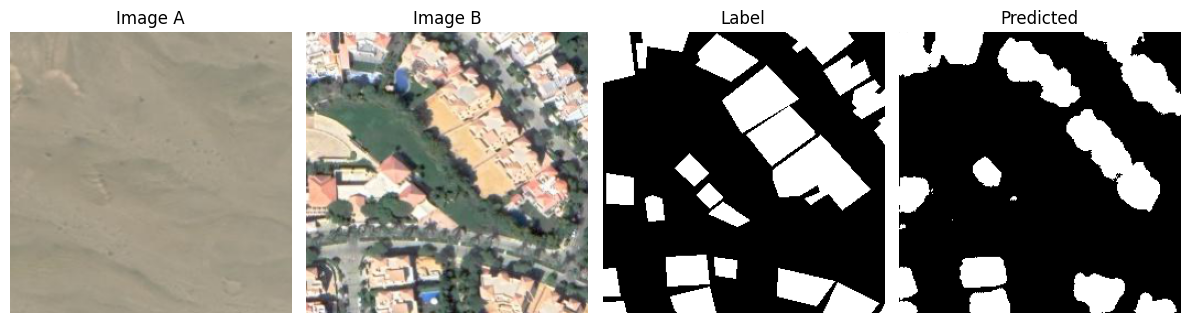

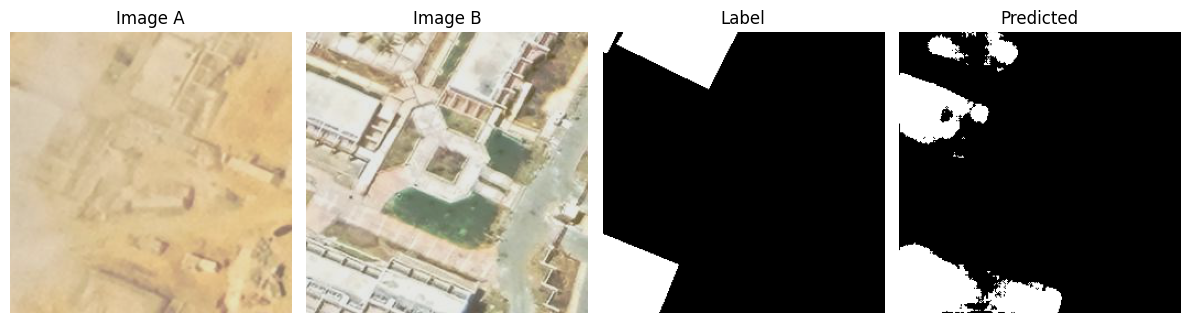

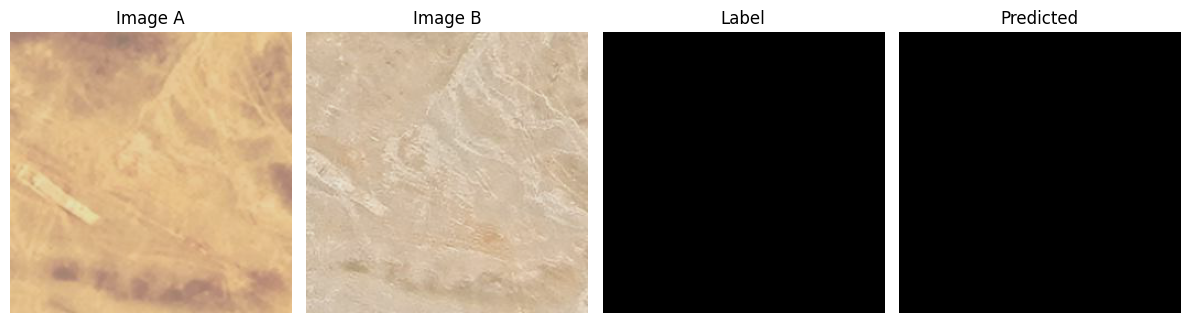

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
start = 4195
end = 4205
with torch.no_grad():
    a = torch.tensor(images_A[start:end], dtype=torch.float32).permute(0, 3, 1, 2) / 255
    b = torch.tensor(images_B[start:end], dtype=torch.float32).permute(0, 3, 1, 2) / 255
    l = torch.tensor(labels[start:end], dtype=torch.float32) / 255
    a, b, l = a.to(device), b.to(device), l.to(device)
    outputs = model(a,b)
    outputs = outputs.reshape((-1,l.shape[1],l.shape[2]))
    outputs_binary = (outputs>0.5) * 1
    val_total_intersections += np.logical_and(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
    val_total_unions += np.logical_or(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
    a, b, l, outputs_binary = a.cpu(), b.cpu(), l.cpu().numpy(), outputs_binary.cpu().numpy()
    for i in range(len(l)):
        fig, axes = plt.subplots(1, 4, figsize=(12, 4))
        # Plot the first image
        axes[0].imshow(a[i].permute(1, 2, 0).numpy())
        axes[0].set_title('Image A')

        # Plot the second image
        axes[1].imshow(b[i].permute(1, 2, 0).numpy())
        axes[1].set_title('Image B')

        # Plot the third image
        axes[2].imshow(l[i].reshape(256,256), cmap='gray')
        axes[2].set_title('Label')

        axes[3].imshow(outputs_binary[i].reshape(256,256), cmap='gray')
        axes[3].set_title('Predicted')

        # Remove the axis labels
        for ax in axes:
            ax.axis('off')

        # Adjust the spacing between subplots
        plt.tight_layout()

        # Show the plot
        plt.show()